In [86]:
import pandas as pd
import numpy as np
import random
import time
from datetime import timedelta
from scipy.stats import uniform, randint, norm

from pathlib import Path
import gdown
import joblib
import gc
import sys

# parent_dir = Path().resolve().parent  # for jupyter nb to be able to find project root
# sys.path.insert(0, str(parent_dir))  # for jupyter nb to be able to find project root

 # for reloading changes w/o kernel restart. Use '%reload_ext autoreload':
%load_ext autoreload
%autoreload 1
%aimport config
from  config import cnfg  # config.py outputs config.yaml as dict, change to scripts.config if move notebook

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split,  GridSearchCV, \
    RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.multioutput import RegressorChain

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def random_color():
    """
    get random matplot-lib colour - just for fun
    """
    color_names = list(mcolors.get_named_colors_mapping().keys())
    color_count = len(color_names)
    random_num = random.randint(0, color_count - 1)
    rand_col = mcolors.get_named_colors_mapping()[color_names[random_num]]
    # if rand_col == "No.":
    #     rand_col = random_color()
    return rand_col

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Data

In [87]:
PATH_TO_DATA = Path(r"C:\\Users\\Peteris\\Documents\\CV\\2025\\shiprojects\\hw_app\\data\\")  # remove after testing
# PATH_TO_DATA = Path(r"C:\\Users\\pich\\Documents\\CV\\2025\\shiprojects\\hw_app\\data\\")  # remove after testing
# PATH_TO_DATA = Path(__file__).parent.parent / "data" # for script
# PATH_TO_DATA = Path.cwd() / "data" # for jupyter
# PATH_TO_DATA = cnfg["data"]["data_dir"]  # get same from config.yaml
# PATH_TO_MODEL = Path(__file__).parent.parent / "models" # for script
PATH_TO_MODEL = Path.cwd() / "models" # for jupyter
# PATH_TO_MODEL = cnfg["data"]["model_dir"]  # get same from config.yaml
PATH_TO_MODEL = Path(r"C:\\Users\\Peteris\\Documents\\CV\\2025\\shiprojects\\hw_app\\models\\")  # remove after testing
# PATH_TO_MODEL = Path(r"C:\\Users\\pich\\Documents\\CV\\2025\\shiprojects\\hw_app\\models\\")  # remove after testing
# file_name = "test-assignment-dataset.json"
file_name = cnfg["data"]["data_filename"]  # get same from config.yaml
# data_url="https://drive.google.com/file/d/1Xx4ozrFDDmzDCuIyUTxjzj43eARpxW1o/view?usp=sharing"
data_url = cnfg["data"]["data_url"]  # get same from config.yaml

In [88]:
def get_and_load_file(
        data_folder:Path=None, filename:str=None,
        url:str=None)->pd.DataFrame:
    """
    Load JSON dataset into a DataFrame. 
    Download JSON dataset from a Google Drive URL, if not already present.
    :param data_folder: Path to the folder where the file should be stored or loaded from.
    :param filename: Name of the file to check, download, and load.
    :param url: Google Drive URL for downloading the file if it's not found locally.
    :return: A pandas DataFrame containing the data from the JSON file.
    """
    data_folder = data_folder or cnfg["data"]["data_dir"]
    file_name = filename or cnfg["data"]["data_filename"]
    url = url or cnfg["data"]["data_url"]
    data_folder.mkdir(parents=True, exist_ok=True)
    local_file_path = data_folder / file_name
    if not Path(local_file_path).is_file():
        print(f"Source data file not in {data_folder}, downloading file")
        gdown.download(url, local_file_path, fuzzy=True, quiet=False)  # quiet=True after testing
    df = pd.read_json(local_file_path)
    return df

df_source = get_and_load_file(data_folder=PATH_TO_DATA)  # change to default "../data/" after testing
target_columns = ["shaftPower", "speedOverGround"]
df_source.sample(3)

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,...,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,recommendedMassFlowRate,expectedSpeedOverGround,recommendedPower,expectedCarbonIntensityIndicator
144455,37.1954,-6.93705,0.0,3.9,337,314.3,5,0.0,0.0,863.422,...,0.0,352.71,1.92,16.55,35.94,0.55,NaN,NaN,NaN,NaN
220099,53.5044,8.51042,0.0,5.9,220,94.4,5,0.0,0.0,870.323,...,1.0,164.00,2.30,6.30,25.49,0.93,NaN,NaN,NaN,NaN
109703,40.4345,29.12220,0.0,4.9,91,25.2,1,0.0,0.0,860.553,...,1.0,141.45,0.99,19.39,20.91,0.00,NaN,NaN,NaN,NaN


### EDA

In [89]:
df_source.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'status', 'mainEngineMassFlowRate',
       'mainEngineVolumeFlowRate', 'mainEngineDensity',
       'mainEngineTemperature', 'mainEngineFuelConsumed',
       'auxEngineMassFlowRate', 'auxEngineVolumeFlowRate', 'auxEngineDensity',
       'auxEngineTemperature', 'shaftSpeed', 'shaftTorque', 'shaftPower',
       'specificFuelOilConsumption', 'timestamp', 'fuelEfficiency',
       'currentDirection', 'currentSpeed', 'gust', 'swellDirection',
       'swellHeight', 'swellPeriod', 'waveDirection', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveHeight', 'windWavePeriod',
       'windDirection', 'windSpeed', 'airTemperature', 'salinity', 'seaLevel',
       'recommendedMassFlowRate', 'expectedSpeedOverGround',
       'recommendedPower', 'expectedCarbonIntensityIndicator'],
      dtype='object')

In [90]:
print(df_source.shape)
df_source.info()

(326224, 43)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326224 entries, 0 to 326223
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   latitude                          326222 non-null  float64            
 1   longitude                         326222 non-null  float64            
 2   speedOverGround                   326224 non-null  float64            
 3   draught                           326220 non-null  float64            
 4   heading                           326224 non-null  int64              
 5   courseOverGround                  326222 non-null  float64            
 6   status                            326224 non-null  int64              
 7   mainEngineMassFlowRate            326224 non-null  float64            
 8   mainEngineVolumeFlowRate          326224 non-null  float64            
 9   mainEngineDensity                 3

In [91]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df_source.describe()

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,mainEngineTemperature,mainEngineFuelConsumed,auxEngineMassFlowRate,auxEngineVolumeFlowRate,auxEngineDensity,auxEngineTemperature,shaftSpeed,shaftTorque,shaftPower,specificFuelOilConsumption,fuelEfficiency,currentDirection,currentSpeed,gust,swellDirection,swellHeight,swellPeriod,waveDirection,waveHeight,wavePeriod,windWaveDirection,windWaveHeight,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,recommendedMassFlowRate,expectedSpeedOverGround,recommendedPower,expectedCarbonIntensityIndicator
count,326222.000000,326222.000000,326224.000000,326220.000000,326224.000000,326222.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,3.262240e+05,3.262240e+05,170130.000000,308207.000000,308207.000000,326224.000000,317216.000000,317084.000000,317084.000000,308135.000000,319809.000000,305432.000000,316981.000000,316956.000000,317216.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,42376.000000,42376.000000,4.237600e+04,41735.000000
mean,49.632092,2.978693,4.950242,5.139615,193.701527,184.906974,2.346624,101.245179,0.117942,815.007951,24.161276,1.687420,6.928908,0.007913,831.910785,29.055252,91.172805,25018.630128,4.726122e+05,1.345341e+04,24.023266,175.602391,0.213010,9.238503,231.826153,0.832728,5.962773,200.727807,1.248696,4.953513,195.791109,0.622706,2.573644,191.147175,6.184837,13.429885,32.111769,0.139154,208.732514,10.394949,1.002439e+06,13.708862
std,7.842426,11.030812,5.310358,0.852991,94.737099,101.332097,2.450708,107.507566,0.125246,180.324604,6.350480,1.791793,5.631603,0.006469,89.815379,4.816925,90.952806,26582.660106,5.129609e+05,1.096295e+06,49.499521,97.980663,0.188869,5.095318,94.955289,1.083965,2.736090,89.367433,1.353802,2.578808,89.104112,0.856438,1.822063,90.703968,3.610953,7.193249,5.866357,0.890680,34.060448,1.817699,1.919168e+05,3.732638
min,35.889400,-23.062100,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,-102.695000,-36.085000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.480000,0.060000,0.010000,1.370000,0.130000,0.000000,1.270000,0.120000,0.000000,0.000000,0.000000,0.170000,-5.090000,8.500000,-3.650000,117.000000,2.714490,4.536688e+05,6.323664
25%,43.360600,-4.751288,0.000000,4.000000,119.000000,104.700000,0.000000,0.000000,0.000000,844.099000,19.763700,0.000000,0.000000,0.000000,833.019000,25.154087,0.230909,561.959000,1.137835e+01,0.000000e+00,16.982491,92.790000,0.090000,5.140000,168.610000,0.100000,3.970000,138.370000,0.390000,2.920000,133.280000,0.090000,1.450000,116.290000,3.350000,6.690000,30.380000,-0.280000,174.000000,9.030438,8.141896e+05,11.299184
50%,51.623500,3.744930,0.200000,5.600000,207.000000,191.400000,1.000000,0.223440,0.000000,859.116000,25.441300,0.003724,8.562600,0.009678,852.911500,29.616125,1.698130,1839.530000,2.460855e+02,1.509878e+02,19.791990,180.000000,0.150000,8.460000,263.920000,0.500000,5.690000,207.890000,0.810000,4.370000,203.150000,0.360000,2.230000,205.400000,5.330000,14.220000,34.920000,0.070000,200.000000,10.428973,9.676852e+05,12.926036
75%,54.436675,8.506670,10.600000,5.900000,271.000000,270.000000,5.000000,208.348250,0.242225,866.413000,27.714200,3.472471,10.602400,0.012155,863.605000,32.971000,182.396000,50966.000000,9.712270e+05,2.136662e+02,22.387983,259.750000,0.300000,12.870000,308.040000,1.060000,7.930000,276.440000,1.750000,5.990000,260.080000,0.790000,3.420000,255.000000,8.220000,19.260000,35.500000,0.550000,246.000000,11.423510,1.190503e+06,15.216035
max,66.328200,32.230000,17.300000,6.000000,359.000000,359.900000,5.000000,572.696000,0.680159,880.345000,149.950000,9.544933,28.019000,0.046928,875.904500,46.816250,185.733000,94223.400000,1.796530e+06,2.832681e+08,3176.

In [92]:
pd.reset_option('all')

C:\Users\Peteris\AppData\Local\Temp\ipykernel_20548\2786130087.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\Peteris\AppData\Local\Temp\ipykernel_20548\2786130087.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


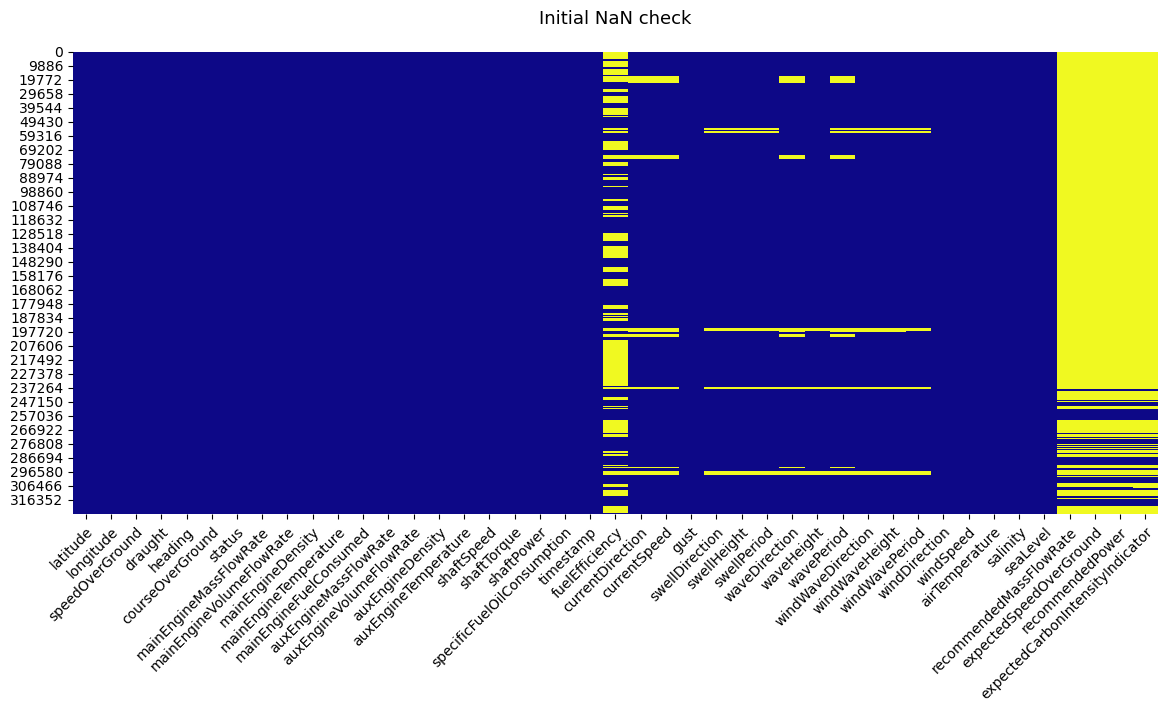

In [93]:
plt.figure(figsize=(df_source.shape[1] // 3, 6))
sns.heatmap(df_source.isnull(), cmap='plasma', cbar=False)
plt.title("Initial NaN check\n", 
          fontsize=13)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

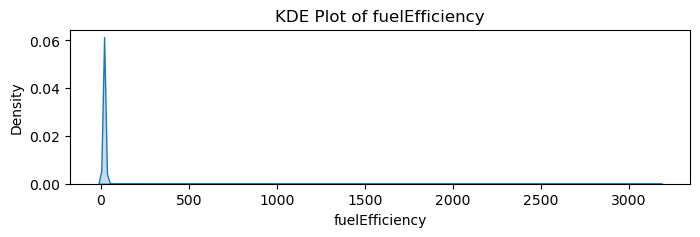

In [94]:
plt.figure(figsize=[8, 2])
sns.kdeplot(data=df_source['fuelEfficiency'].dropna(), fill=True)
plt.title('KDE Plot of fuelEfficiency')
plt.xlabel('fuelEfficiency')
plt.ylabel('Density')
plt.show()

In [95]:
df_source['fuelEfficiency'].value_counts(dropna=True, ascending=False, normalize=True).head(5)

fuelEfficiency
0.00     0.065826
20.55    0.000035
18.66    0.000029
19.74    0.000024
16.52    0.000024
Name: proportion, dtype: float64

In [96]:
nan_rows = df_source[df_source.loc[:, 'currentDirection':'seaLevel'].isnull().any(axis=1)].index  # rows, where specified columns contain NaNs
print(f"proportion of rows containing nan values in selected rows ('currentDirection':'seaLevel') \
against entire dataset:\n{round(len(nan_rows)/df_source.shape[0]*100, 1)}%")

proportion of rows containing nan values in selected rows ('currentDirection':'seaLevel') against entire dataset:
6.4%


In [97]:
print(f"Correlation between sparsely populated 'expected' and 'registered' speeds over ground:\
    {df_source["speedOverGround"].corr(df_source["expectedSpeedOverGround"])}")
print(f"Correlation between sparsely populated 'recommended' and 'registered' mass flow rates:\
    {df_source["mainEngineMassFlowRate"].corr(df_source["recommendedMassFlowRate"])}")
print(f"Correlation between sparsely populated 'recommended' and 'registered' power:\
    {df_source["shaftPower"].corr(df_source["recommendedPower"])}")


Correlation between sparsely populated 'expected' and 'registered' speeds over ground:    0.30263690090074735
Correlation between sparsely populated 'recommended' and 'registered' mass flow rates:    0.5643054263353686
Correlation between sparsely populated 'recommended' and 'registered' power:    0.6290641912284795


In [98]:
def display_distributions(data: pd.DataFrame, features: list[str], 
                          title_prefix: str=None):
    """Display distribution graphs for specified categorical columns.
    Graphs are displayed as a vertical stack of box plots.
    :param data: DataFrames with numerical categories for visualization.
    :param features: list of column names/features  from 'data' Dataframe.
    :param title_prefix: Optional, prefix for visualization title.
    """
    n_subplots = len(features) * 2
    fig, axs = plt.subplots(nrows=n_subplots, figsize = (15,n_subplots*2))
    index = 0
    for feature in features:
        sns.boxenplot(data=data,
                      x=data[feature], color=random_color(), ax=axs[index])
        sns.kdeplot(data=data,
                      x=data[feature], color=random_color(), ax=axs[index+1])
        index += 2
        
    if title_prefix:
        fig.suptitle(f"{title_prefix} feature distribution analysis", fontsize=18)
    else:
        fig.suptitle(f"Features distribution analysis", fontsize=18)
    fig.tight_layout()

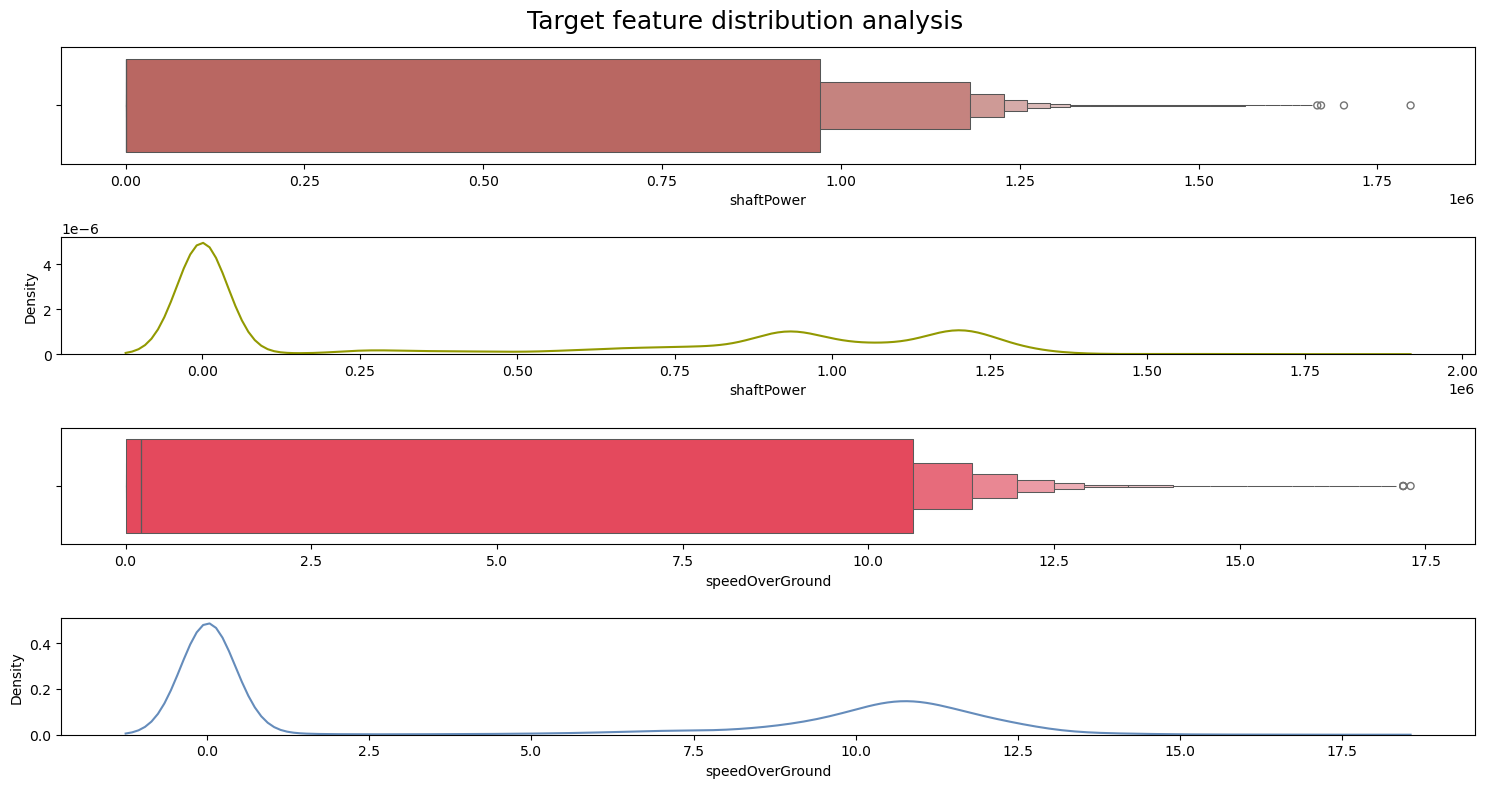

In [99]:
display_distributions(
    data=df_source,
    features=target_columns, title_prefix="Target")

#### Experiments with log and box-cox transformation to improve target distributions (uncomment if wish to see results):

In [100]:
# df_log = df_source.copy()
# df_log[target_columns] = np.log1p(df_log[target_columns])

In [101]:
# display_distributions(
#     data=df_log,
#     features=target_columns, title_prefix="Log transformed Target")

In [102]:
# df_yeo = df_source.copy()
# pt = PowerTransformer(method='box-cox')
# df_yeo[target_columns] = pt.fit_transform(df_yeo[target_columns] + 1e-5)

In [103]:
# display_distributions(
#     data=df_yeo,
#     features=target_columns, title_prefix="Box-Cox transformed Target")

- #### With only ~6% of rows containing missing values for weather data, I will delete them in training task:
    - To decide on best imputation strategy for missing environmental data (weather, sea conditions) domain expert is needed on:
        - whether mean/mode imputation is sufficient
        - Does dataset structure (eg row sequence, timestamp) has sufficient for k-neighbors imputation
        - does other columns are sufficient predictors to use regression imputation
- #### Drop sparsely populated 'expected' and 'recommended' engine data features:
    - Correlations between 'expected'/'recommended' features range wro weak to strong.
    - Thus some of them could be useful for model training.
    - However, cleaning up their missing values is not feasible unless these features have particular importance according to domain expert opinion (missing in this exercise).
- #### Replace 'fuelEfficiency' NaNs with zeroes as it is most popular value among "good" entries for the feature anyway
- #### Both targets `shaftPower` and `speedOverGround` are right skewed, multimodal with medians approaching zero. `shaftPower` has outliers in range exceeding 1.5 MW:
    - remove rows containing outlier data in `shaftPower`.
    - Considered log or Yeo-Johnson transformation for `shaftPower` due to zero median, skewness and multimodality. None of the two solved multimodality problem. However, tree/ensemble should handle multimodality reasonably well.

### Data Preprocessing

In [104]:
def clean_data(data:pd.DataFrame, nan_col_start:str = "latitude",
               nan_col_end:str = "seaLevel", cols_to_dorp:list[str]=None,
               nan_to_zero_columns:list[str] = None,
               outlier_removal:list[list]=None, 
               )->pd.DataFrame:
    """
    Clean and preprocess the dataset for modeling:
    1) Create a deep copy of the input dataset to preserve the original data.
    2) Fill missing values in the specified columns with 0.
    3) Identify and drop rows with any NaN values between specified columns (inclusive).
    4) Remove predefined columns unrelated to model input.
    5) Drop columns that contain single unique value (not useful for ML algorithm).
    6) Remove outlier rows for specified columns within specified percentile range.
    3) convert all numeric columns to pd.Series compatible float32 for resource 
            saving and scikit learn compatibility (e.g. RegressorChain).

    :param data: Input DataFrame to be cleaned.
    :param nan_col_start: Column name where NaN checking should begin (inclusive).
    :param nan_col_end: Column name where NaN checking should end (inclusive).
    :param cols_to_dorp: Column names to drop from dataframe. Optional. 
                            Defaults to config file values.
    :param nan_to_zero_columns: specify a list of columns where NaN values will be replaced by 0. 
                                    Defaults to config file values.
    :param outlier_removal: list of lists that consist of column name, lower and upper 
                                percentile (float) for outlier row removal.
    :return: A cleaned DataFrame with rows and columns filtered and missing data handled.
    """
    df_new = data.copy(deep=True)
    cols_to_dorp = cols_to_dorp or cnfg["data"]["data_cleaning"]["columns_to_drop"]
    if nan_to_zero_columns is not None:
        nan_to_zero = nan_to_zero_columns
    elif "columns_nan_to_zero" in cnfg["data"]["data_cleaning"]:
        nan_to_zero = cnfg["data"]["data_cleaning"]["columns_nan_to_zero"]
    else:
        nan_to_zero = []
    for column in nan_to_zero:
        df_new[column] = df_new[column].fillna(0)
    nan_rows = df_new[df_new.loc[:, nan_col_start:nan_col_end].isnull().any(axis=1)].index
    df_new = df_new.drop(index=nan_rows)
    df_new = df_new.drop(columns=cols_to_dorp)

    df_new = df_new.drop(columns=[col for col in df_new.columns 
                                  if df_new[col].nunique(dropna=False) == 1])

    if outlier_removal:
        for  feature, lower, upper in outlier_removal:
            df_new = df_new[(df_new[feature] >= df_new[feature].quantile(lower)) 
                            & (df_new[feature] <= df_new[feature].quantile(upper))]
            
    numeric_cols = df_new.select_dtypes(include=np.number).columns
    df_new[numeric_cols] = df_new[numeric_cols].astype(np.float32)

    return df_new

df_clean = clean_data(df_source,
                      outlier_removal=[["shaftPower", 0, 0.999]]
                      )
df_clean.shape

(305120, 39)

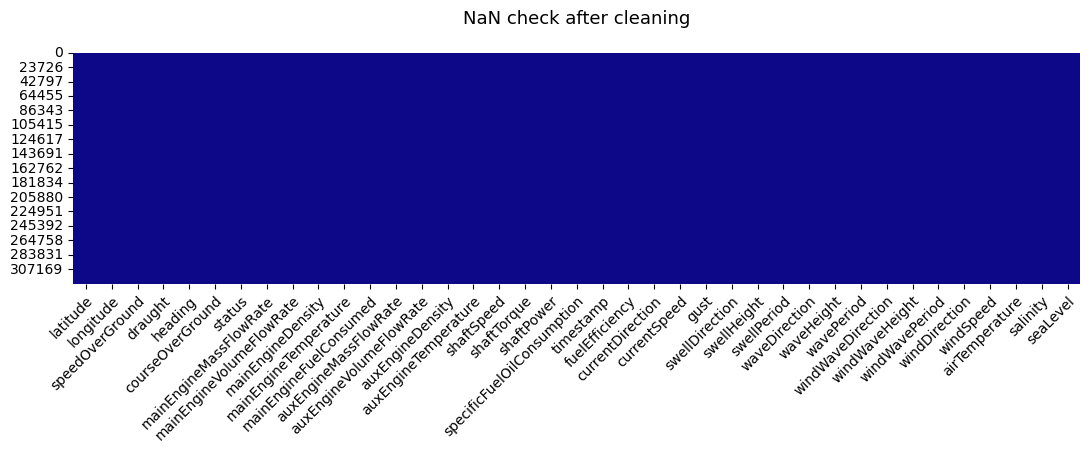

In [105]:
plt.figure(figsize=(df_clean.shape[1] // 3, 3))
sns.heatmap(df_clean.isnull(), cmap='plasma', cbar=False)
plt.title("NaN check after cleaning\n", 
          fontsize=13)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Feature Selection 

In [106]:
f"Dates in 'timestamp' feature range from {min(df_clean["timestamp"])} to {max(df_clean["timestamp"])}."

"Dates in 'timestamp' feature range from 2024-07-26 10:24:00+00:00 to 2025-03-12 23:59:00+00:00."

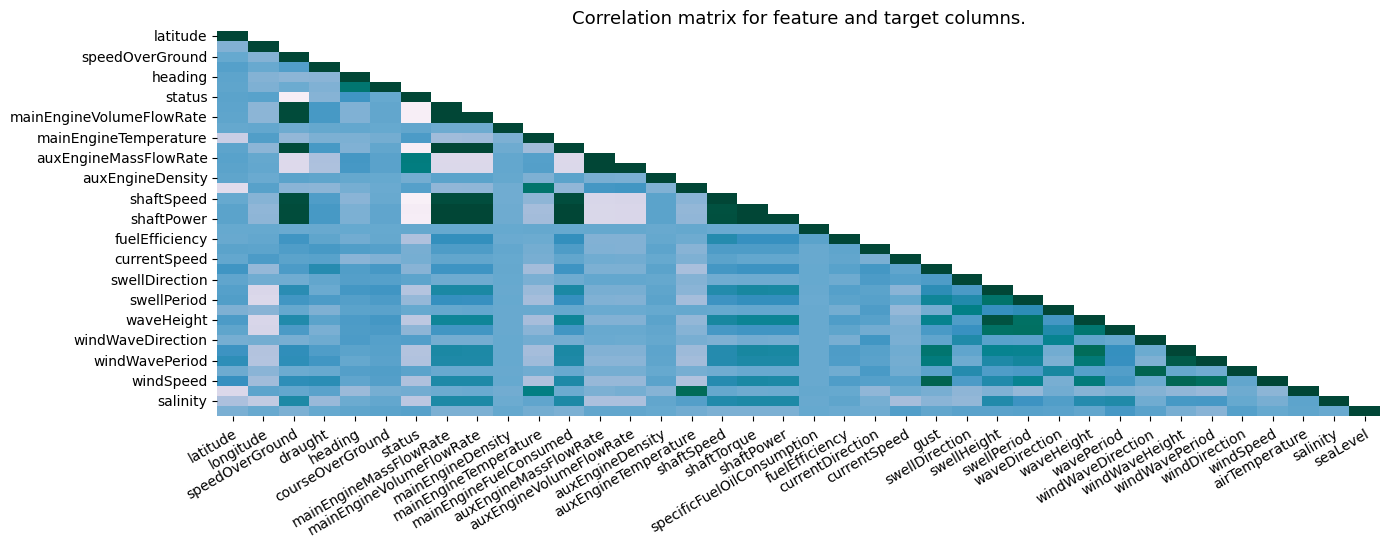

In [107]:
def compute_correlations_matrix(data:pd.DataFrame=df_clean)->pd.DataFrame:
    """
    Compute and display a heatmap of the correlation matrix for numerical features.    
    :param dataset: pandas DataFrame containing the input data.
    :return: pandas DataFrame of the correlation matrix.
    """
    plt.figure(figsize=(15, 5))
    correlation_matrix = data.select_dtypes(include='number').corr()
    triangular_matrix = np.triu(correlation_matrix, k=1)

    sns.heatmap(
      data=correlation_matrix,
      center=0,
      cmap= 'PuBuGn',
      cbar=False,
      annot=False,
      mask=triangular_matrix
    )
    plt.xticks(rotation=30,ha='right', rotation_mode="anchor")
    plt.title("Correlation matrix for feature and target columns.", fontsize=13);
    return correlation_matrix


correlations = compute_correlations_matrix(df_clean)

In [108]:
def top_correlations(data:pd.DataFrame=df_clean, corr_threshold:float=0.95)->pd.Series:
    """
    Identify and return highly correlated feature pairs above a specified threshold.
    :param data: pandas DataFrame containing the input dataset. Defaults to df_clean.
    :param corr_threshold: Correlation threshold to filter feature pairs. Default is 0.95.
    :return: A pandas Series with multi-index (feature pairs) and correlation values.
    """
    corrs = data.select_dtypes(include='number').corr()
    corrs = corrs.unstack().sort_values(ascending=False)
    corrs = corrs[(corrs.abs() > corr_threshold) & 
                        (corrs.index.get_level_values(0) != corrs.index.get_level_values(1))]
    corrs = corrs.drop_duplicates()
    return corrs

sorted_corr = top_correlations()

print(f"Features with correlation exceeding 0.95:")
sorted_corr

Features with correlation exceeding 0.95:


mainEngineFuelConsumed    mainEngineMassFlowRate      1.000000
shaftPower                shaftTorque                 0.999864
mainEngineVolumeFlowRate  mainEngineFuelConsumed      0.999709
mainEngineMassFlowRate    mainEngineVolumeFlowRate    0.999709
auxEngineMassFlowRate     auxEngineVolumeFlowRate     0.998790
shaftPower                mainEngineFuelConsumed      0.997489
mainEngineMassFlowRate    shaftPower                  0.997489
shaftPower                mainEngineVolumeFlowRate    0.997246
mainEngineFuelConsumed    shaftTorque                 0.996993
shaftTorque               mainEngineMassFlowRate      0.996993
mainEngineVolumeFlowRate  shaftTorque                 0.996629
                          speedOverGround             0.962003
speedOverGround           mainEngineMassFlowRate      0.961377
mainEngineFuelConsumed    speedOverGround             0.961377
speedOverGround           shaftPower                  0.954996
                          shaftTorque                 0

### Conclusion: multicollinearity detected, conduct feature selection:
- #### 	Drop/Combine/Regularize if linear (including ridge or lasso) or even SVM regressions used
- #### feature still selection recommended for tree based or Gradient Boosting models
- #### Will drop drop potentially derived or redundant features:
    - #### `mainEngineFuelConsumed`: Possibly a computed value from mass flow
    - #### `shaftTorque`: derived from `mainEngineMassFlowRate` and target `shaftPower`
    - #### 	`auxEngineVolumeFlowRate` and `mainEngineVolumeFlowRate`: Volume flow might be calculated from mass flow
    - #### `mainEngineFuelConsumed`: same as `mainEngineMassFlowRate` measures fuel movement

In [109]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Remove selected features (columns) from the input DataFrame.
    Inherits from scikit-learn's BaseEstimator and TransformerMixin 
            for scikit-learn pipeline compatibility.
     Used to simplify datasets by excluding specified columns during preprocessing.
    :param data: pandas DataFrame to process.
    :param features_to_drop: List of column names to drop.
        Defaults to config file values.
    """

    def __init__(self, features_to_drop:list=None):
        """"
        Initialize with the provided data and feature configurations.
        Store the list of features to drop for later use in transformation.
        """
        self.features_to_drop = features_to_drop or cnfg[
            "data"]["data_preprocessing"]["collinear_features"]


    def fit(self, X, y=None):
        """
        Fit method for compatibility with scikit-learn pipelines.
        Does not perform any fitting operation.
        """
        return self
    

    def transform(self, X: pd.DataFrame, feature_to_drop:list=None)->pd.DataFrame:
        """
        Remove specified features (columns) from the input DataFrame.
        Uses instance-level 'features_to_drop' unless an override list is provided.
        :param X: input data.
        :param features_to_drop: List of column names to drop.
        :return: A new pandas DataFrame with the specified features removed.
        """
        df_new = X.copy(deep=True)
        features = feature_to_drop or self.features_to_drop
        if features:
            df_new = df_new.drop(columns=features)
            
        return df_new

In [110]:
collinear_features=[
    "mainEngineFuelConsumed",
    "shaftTorque", 
    "auxEngineVolumeFlowRate", 
    "mainEngineVolumeFlowRate",
    ]

# feature_selector = FeatureSelector(features_to_drop=collinear_features)
feature_selector = FeatureSelector()  # load 'features_to_drop' from config file

df_feat_sel = feature_selector.transform(X=df_clean)
df_feat_sel.shape

(305120, 35)

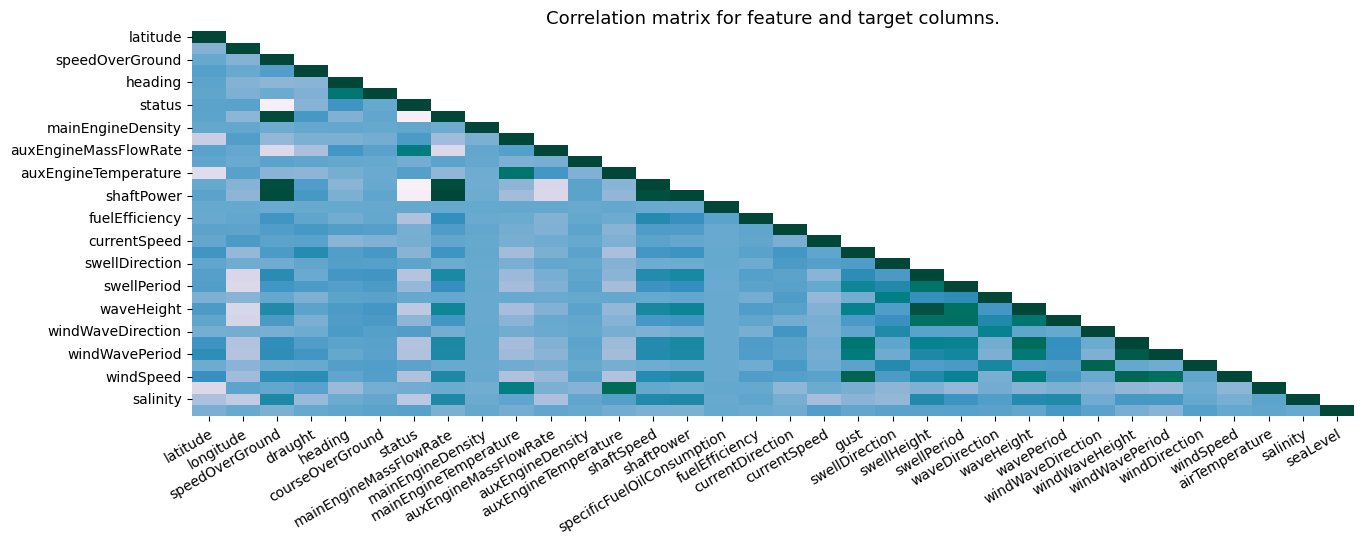

In [111]:
correlations = compute_correlations_matrix(df_feat_sel)

In [112]:
# Remove after testing
correlations_threshold = 0.95
sorted_corr_f = top_correlations(data=df_feat_sel, corr_threshold=correlations_threshold)

print(f"Features with correlation exceeding {correlations_threshold}:")
sorted_corr_f

Features with correlation exceeding 0.95:


shaftPower       mainEngineMassFlowRate    0.997489
speedOverGround  mainEngineMassFlowRate    0.961377
shaftPower       speedOverGround           0.954996
dtype: float64

**Conclusion**: High correlations remaining are target features and `mainEngineMassFlowRate` identified as must-have by task description. Thus those will remain.

### Feature Engineering

In [113]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Engineer features: angular, force interaction and time.
    Inherits from scikit-learn's BaseEstimator and TransformerMixin 
            for scikit-learn pipeline compatibility.
    :param angular_features: List of angle-based feature column names (in degrees).
                                Defaults to config file values.
    :param env_force_features: List of (angle feature, force feature) pairs for decomposing forces.
                                Defaults to config file values.
    :param base_angle_feats: Reference angle column name (default, 'heading' from config file).
    :param base_time_feats: Column name for timestamp (default, 'timestamp' from config file).
    :param drop_original_features: Flag to optionally remove original features a self.base_angle_feat 
                                    class level with 'transform()' method.
    """


    def __init__(self,
                 angular_features: list[str] = None,
                 env_force_features: list[list] = None,
                 base_angle_feats: str = None,
                 base_time_feats: str = None,
                 drop_original_features: bool = False
                 ):
        """
        Initialize with the provided data and feature configurations.
        Store configuration parameters for use in transformations.
        """
        self.angular_features = angular_features or cnfg["feature_engineering"]["angular_features"]
        self.env_force_features = env_force_features or cnfg["feature_engineering"][
            "environment_forces_features"]
        self.base_angle_feats = base_angle_feats or cnfg["feature_engineering"]["base_angle_feature"]
        self.base_time_feats = base_time_feats or cnfg["feature_engineering"]["base_time_feature"]
        self.drop_original_features = drop_original_features
        self._transformed_feature_names = None


    def fit(self, X: pd.DataFrame, y=None):
        """
        Fit method for compatibility with scikit-learn pipelines.
        Does not perform any fitting operation.
        """
        if hasattr(X, "columns"):
            self.feature_names_in_ = X.columns
        else:
            self.feature_names_in_ = None

        return self
    
    
    @property
    def feature_names_out_(self):
        """
        Getter for feature names after transformations.
        If transformations have been applied, return the column names.
        """
        return self._transformed_feature_names
    

    @staticmethod
    def compute_relative_angle(angle1, angle2):
        """
        Compute absolute minimal angle difference between two angles (in degrees).
        :param angle1: First angle or Series of angles.
        :param angle2: Second angle or Series of angles.
        :return: Absolute minimal angular difference in degrees.
        """
        return np.abs(((angle1 - angle2 + 180) % 360) - 180)
    

    @staticmethod
    def drop_columns(data:pd.DataFrame, drop_list:list[str]):
        """
        Drop specified columns from the DataFrame.
        Check for presence of 'drop_list' features in DataFrame.
        :param data: DataFrame to modify.
        :param drop_list: List of column names to drop.
        :return: Modified DataFrame with columns removed.
        """
        data.drop(
            columns=[col for col in drop_list if col in data.columns],
            errors='ignore',
            inplace=True
            )
        
        return data


    def transform_angles(self,
                        X: pd.DataFrame,
                        angular_feature: list[str] = None,
                        drop_source_feature: bool = False) -> pd.DataFrame:
        """
        Compute relative angles between angular features and base_angle_feat.
        This feature provides if various external forces (current, wind, etc) facilitate 
            or counteract ship's course.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param angular_feature: List of angle-based feature column names (in degrees).
        :param drop_source_feature: Flag to drop original angle columns (default, False).
        :return: DataFrame with added relative angle features.
        """
        df_angle = X.copy(deep=True)
        features = angular_feature or self.angular_features

        for angle_feature in features:
            if angle_feature in df_angle.columns\
                and self.base_angle_feats in df_angle.columns:
                angle_to_heading = self.compute_relative_angle(
                    df_angle[angle_feature], df_angle[self.base_angle_feats])

                df_angle.insert(loc=df_angle.columns.get_loc(angle_feature) + 1,
                                column=angle_feature + '_rel_head',
                                value=angle_to_heading,
                                allow_duplicates=True)
                
        df_angle = df_angle.loc[:, ~df_angle.columns.duplicated()]  
        if drop_source_feature:
            df_angle = self.drop_columns(data=df_angle, drop_list=features+[self.base_angle_feats])
   
        return df_angle


    def transform_force_components(self,
                                   X: pd.DataFrame,
                                   env_force_feature: list[tuple] = None,
                                   drop_source_feature: bool = False) -> pd.DataFrame:
        """
        Add force features based on relative angle to base_angle_feat.
        This feature provides index for external forces (current, wind, etc) speed and angle
             counteracting ship's course. Higher index means stronger tail/cross components.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param env_force_feature: List of (angle_col, force_col) pairs for decomposing forces.
        :param drop_source_feature: Flag to drop original force columns (default, False).
        :return: DataFrame with new force features.
        """
        df_force = X.copy(deep=True)
        features = env_force_feature or self.env_force_features

        for angle_col, force_col in features:
            if angle_col in df_force.columns\
            and force_col in df_force.columns\
            and self.base_angle_feats in df_force.columns:
                rel_angle_rad = np.radians(
                    self.compute_relative_angle(
                        df_force[angle_col], df_force[self.base_angle_feats]))
                idx_force = df_force.columns.get_loc(force_col)

                df_force.insert(loc=idx_force + 1,
                                column=force_col + "_head",
                                value=df_force[force_col] * np.cos(rel_angle_rad),
                                allow_duplicates=True)

                # Insert cross-wind/current component
                df_force.insert(loc=idx_force + 1,
                                column=force_col + "_cross",
                                value=df_force[force_col] * np.sin(rel_angle_rad),
                                allow_duplicates=True)
            
                if drop_source_feature:
                    df_force = self.drop_columns(data=df_force, drop_list=[angle_col, force_col])
            
        df_force = df_force.loc[:, ~df_force.columns.duplicated()]
                
        return df_force
    

    def eng_direction_features(self,
                               X: pd.DataFrame, 
                                angular_feature: list[str] = None,
                                drop_source_feature: bool=False
                                )->pd.DataFrame:
        """
        Engineer sine and cosine components of directional features to preserve circularity.
        New sine and cosine features address issue arising from circularity of angle features
                     - e.g. that after 360 comes 0.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param angular_feature: List of directional feature columns (in degrees).
        :param drop_source_feature: Flag to drop original direction columns (default, False).
        :return: DataFrame with sine and cosine of directional features.
        """
        df_direction = X.copy(deep=True)
        features = angular_feature or self.angular_features

        for angle_feature in features:
            if angle_feature in df_direction.columns\
                and self.base_angle_feats in df_direction.columns:
                orig_feat_index = df_direction.columns.get_loc(angle_feature)
                df_direction.insert(loc=orig_feat_index+1,
                                    column=angle_feature+'_sin',
                                    value=np.sin(2 * np.pi * df_direction[angle_feature] / 360),
                                    # value=np.sin(np.radians(df_direction[feature])),
                                    allow_duplicates=True)
                df_direction.insert(loc=orig_feat_index+1,
                                    column=angle_feature+'_cos',
                                    value=np.cos(2 * np.pi * df_direction[angle_feature] / 360),
                                    # value=np.cos(np.radians(df_direction[feature])),
                                    allow_duplicates=True)

        if drop_source_feature:
            df_direction = self.drop_columns(data=df_direction, drop_list=features)
        df_direction = df_direction.loc[:, ~df_direction.columns.duplicated()]

        return df_direction
    

    def eng_circular_time_feats(self,
                                X: pd.DataFrame,
                                base_time_feat: str = None,
                                ):
        """
        Create hour and month features from timestamp. 
        Both potentially indicate daily or seasonal weather patterns 
                    affecting ship's speed and engine workloads.
        Calculate sines and cosines to preserve circularity - e.g. that after 23 or 12 comes 0/1.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Convert timestamp column to data type if required.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Drop original column as most models will not process timestamp objects.
        :param X: input data.
        :param base_time_feat: Column name containing time information (default, None).
        :param drop_source_feature: Flag to drop original timestamp columns (default, False).
        :return: DataFrame with sine and cosine components of the hour feature.
        """
        df_time = X.copy(deep=True)
        time_feature = base_time_feat or self.base_time_feats
        if time_feature in df_time.columns:
            if not pd.api.types.is_datetime64_any_dtype(df_time[time_feature]):
                df_time[time_feature] = pd.to_datetime(df_time[time_feature], errors='coerce')
            idx_time = df_time.columns.get_loc(time_feature)
            new_time_features = [("hours", df_time[time_feature].dt.hour, 24),
                                 ("months", df_time[time_feature].dt.month, 12)]

            for name, values, circular_divisor in new_time_features:
                df_time.insert(loc=idx_time+1,
                                    column=name + "_sin",
                                    value=np.sin(2 * np.pi * values / circular_divisor),
                                    allow_duplicates=True)
                df_time.insert(loc=idx_time+1,
                                    column=name + "_cos",
                                    value=np.cos(2 * np.pi * values / circular_divisor),
                                    allow_duplicates=True)
            df_time = self.drop_columns(df_time, [time_feature])

        return df_time


    def transform(self, X:pd.DataFrame) -> pd.DataFrame:
        """
        Apply transformations to angles, forces, directions, and power-to-speed ratio.
        Calls all 'FeatureEngineer' feature engineering steps sequentially and removes duplicates.
        Uses 'FeatureEngineer' instance-level 'drop_original_features' flag to remove original features.
        :param X: input data.
        :return: Transformed DataFrame with engineered features.
        """
        if not hasattr(X, "columns"):
            df = pd.DataFrame(X, columns=self.feature_names_in_)
        elif isinstance(X, pd.DataFrame):
            df = X.copy(deep=True)
        df = self.transform_angles(X=df)
        df = self.transform_force_components(X=df, drop_source_feature=self.drop_original_features)
        df = self.eng_direction_features(X=df, drop_source_feature=self.drop_original_features)
        df = self.eng_circular_time_feats(X=df)
        if self.drop_original_features is not False:
            df = self.drop_columns(data=df, drop_list=[self.base_angle_feats])
        df = df.loc[:, ~df.columns.duplicated()]
        self._transformed_feature_names = df.columns.tolist()

        return df

In [114]:
# engineer = FeatureEngineer(
#     angular_features=[
#         "windDirection",
#         "currentDirection",
#         "waveDirection",
#         "swellDirection",
#         "windWaveDirection"
#         ],
#     env_force_features=[
#         ["windDirection","windSpeed"],
#         ["currentDirection", "currentSpeed"]
#         ],
#     drop_original_features=False,
# )
engineer = FeatureEngineer()  # get variables from config file
df_feat_eng = engineer.transform(X=df_feat_sel)
df_feat_eng.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'status', 'mainEngineMassFlowRate',
       'mainEngineDensity', 'mainEngineTemperature', 'auxEngineMassFlowRate',
       'auxEngineDensity', 'auxEngineTemperature', 'shaftSpeed', 'shaftPower',
       'specificFuelOilConsumption', 'months_cos', 'months_sin', 'hours_cos',
       'hours_sin', 'fuelEfficiency', 'currentDirection',
       'currentDirection_cos', 'currentDirection_sin',
       'currentDirection_rel_head', 'currentSpeed', 'currentSpeed_cross',
       'currentSpeed_head', 'gust', 'swellDirection', 'swellDirection_cos',
       'swellDirection_sin', 'swellDirection_rel_head', 'swellHeight',
       'swellPeriod', 'waveDirection', 'waveDirection_cos',
       'waveDirection_sin', 'waveDirection_rel_head', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveDirection_cos',
       'windWaveDirection_sin', 'windWaveDirection_rel_head', 'windWaveHeight',
       'windWavePeri

In [115]:
df_feat_eng.sample(1)

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineDensity,mainEngineTemperature,...,windDirection,windDirection_cos,windDirection_sin,windDirection_rel_head,windSpeed,windSpeed_cross,windSpeed_head,airTemperature,salinity,seaLevel
131227,39.969501,0.025742,0.0,5.9,141.0,23.799999,5.0,0.0,864.979004,26.02,...,45.459999,0.701407,0.712761,95.540001,6.79,6.758284,-0.655511,18.379999,37.34,0.06


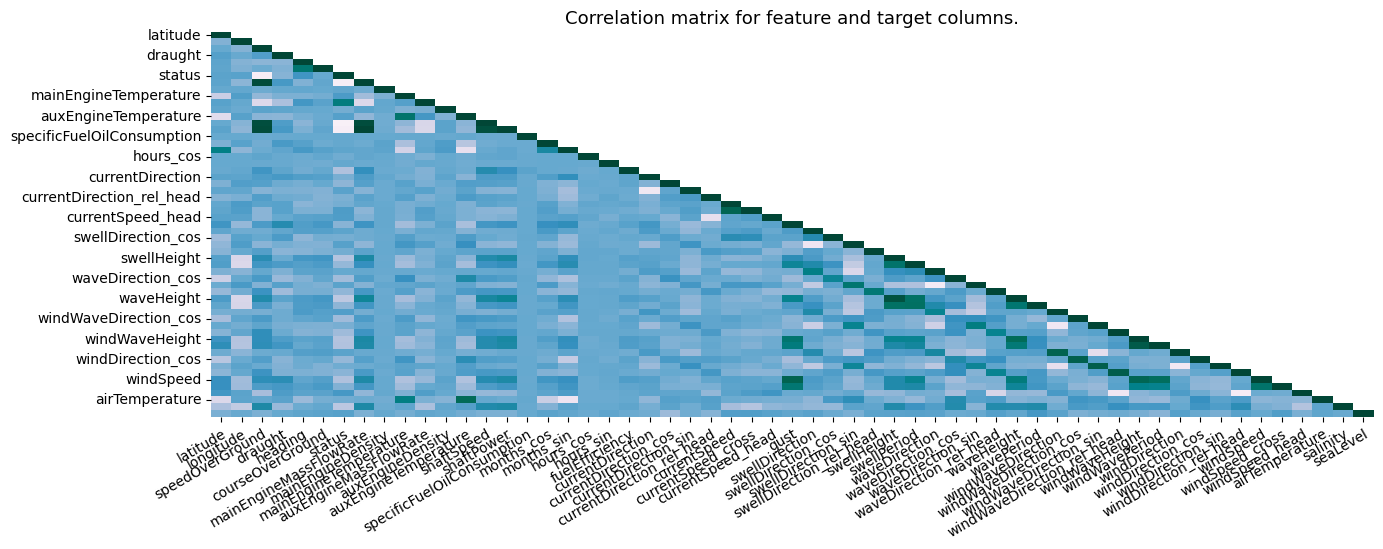

In [116]:
correlations = compute_correlations_matrix(df_feat_eng)

In [117]:
correlations_threshold = 0.90
sorted_corr_f = top_correlations(data=df_feat_eng, corr_threshold=correlations_threshold)

print(f"Features with correlation exceeding {correlations_threshold}:")
sorted_corr_f

Features with correlation exceeding 0.9:


shaftPower              mainEngineMassFlowRate    0.997489
speedOverGround         mainEngineMassFlowRate    0.961377
shaftPower              speedOverGround           0.954996
mainEngineMassFlowRate  shaftSpeed                0.945977
shaftSpeed              speedOverGround           0.937545
                        shaftPower                0.926743
swellHeight             waveHeight                0.914593
shaftSpeed              status                   -0.913061
dtype: float64

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clean.drop(columns=target_columns),
    df_clean[target_columns],
    test_size=0.2,
    # random_state=42
    )

### Model Selection

#### Training and Evaluation:
- #### Create 2 datasets and run models on them:
    - with original and multicollinear features for trees/ensembles.
    - without or original features and target distribution transformation for all test models.
    - as well as experiment with Lasso feature selection for linear models.
- #### Toolstack:
    - Scikit-learn `Pipeline` for pre-processing steps
    - models nested/chained in `RegressorChain()` for correlated multi-target predictions.
    - Known limitation: `RegressorChain(Pipeline)` fails if Pipeiline's last step has been a model.
    - Nesting `RegressorChain` within `Pipeline` may break `RegressorChain` logic of using predictions for one target to improve predictions of further targets.

In [80]:
def evaluation_tabel(
        predictions: np.ndarray,
        y_true: pd.DataFrame = y_test,
        target_index: list[str] = None,
        original_dataset_correlations: pd.Series= None,
        ) -> pd.DataFrame:
    """
    Get model evaluation table with MAE, RMSE and R2 metrics.
    MAPE calculation excludes all 0 values for True values.
    Optionally add highest correlation scores between target and source features.
    :param y_true: target data with true values.
    :param predictions: model predictions.
    :param target_index: names of target labels. Defaults to values from config file.
    :param original_dataset_correlations: correlation matrix of the 
        source dataset that includes target columns with 2 level multi-index.
    :return: DataFrame with target labels as rows an model evaluation 
                metrics as columns.
    """
    targets = target_index or cnfg["data"]["target_columns"]
    df_metrics = pd.DataFrame(index=targets)
    df_metrics["RMSE"] = np.sqrt(mean_squared_error(y_pred=predictions, 
                                                    y_true=y_true, 
                                                    multioutput="raw_values"))
    df_metrics["MAE"] = mean_absolute_error(y_pred=predictions, y_true=y_true,
                                            multioutput="raw_values")
    df_metrics["R2"] = r2_score(y_pred=predictions, y_true=y_true,
                                multioutput="raw_values")
    non_zero_mask = y_true != 0
    df_metrics["masked_MAPE"] = np.mean(np.abs((y_true[non_zero_mask.all(axis=1)
                                                ] - predictions[np.all(non_zero_mask, axis=1)]) / (
                                                    y_true[non_zero_mask.all(axis=1)])), axis=0
                                                    ) * 100
    if original_dataset_correlations is not None:
        for target in targets:
            target_corrs  = original_dataset_correlations[
                (original_dataset_correlations.index.get_level_values(0) == target)
                  | (original_dataset_correlations.index.get_level_values(1) == target)]
            if target_corrs.empty:
                df_metrics.at[target, "max_corr_w_orig_feat"] = np.nan
            else:
                df_metrics.at[target, "max_corr_w_orig_feat"] = target_corrs.max()                
            
    return df_metrics

In [81]:
#Define correlation matrix at 80% level so that target "speedOverGround" is included for model evaluation table.
sorted_corr_80 = top_correlations(data=df_clean, corr_threshold=0.8)

##### Max features included, also collinear, no scaling.

In [36]:
colliner_insensitive = {
    "xgb_model": XGBRegressor(),
    "rf_model": RandomForestRegressor(n_jobs=1)
    }

In [37]:
engineer_max_features = FeatureEngineer(
    angular_features=[
        "windDirection",
        "currentDirection",
        "waveDirection",
        "swellDirection",
        "windWaveDirection"
        ],
    env_force_features=[
        ("windDirection","windSpeed"),
        ("currentDirection", "currentSpeed")
        ],
    drop_original_features=False,
)

In [ ]:
%%time
filename_prefix = "max_features_"
preprocessor_path = PATH_TO_MODEL / f"{filename_prefix}prep.pkl"

if preprocessor_path.is_file():
    preprocess_max = joblib.load(preprocessor_path)
else:
    preprocess_max = Pipeline([
        ("engineer_features", engineer_max_features),
        ])
    preprocess_max.fit(X_train)
    joblib.dump(value=preprocess_max, filename=preprocessor_path)

for name, model in colliner_insensitive.items():
    start = time.perf_counter()
    model_path = PATH_TO_MODEL / f"{filename_prefix}{name}.pkl"
    if model_path.is_file():
        chain_model_max = joblib.load(model_path)
    else:
        X_train_prep = preprocess_max.fit_transform(X_train)
        chain_model_max = RegressorChain(model).fit(X_train_prep, y_train)
        joblib.dump(value=chain_model_max, filename=model_path)
        
    y_pred = chain_model_max.predict(preprocess_max.transform(X_test))
    end = time.perf_counter()
    gc.collect()  # clean up unreachable objects in memory
    print(f"Training and/or inference for {name} takes {timedelta(seconds=end - start)}.")
    print(f"Evaluation table for {name}.")
    print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")

# With training:
# CPU times: total: 58min 8s
# Wall time: 58min 18s
# inference only (mostly SVR):
# CPU times: total: 18.2 s
# Wall time: 20.7 s

Training and/or inference for xgb_model takes 0:00:01.631910.
Evaluation table for xgb_model.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       1946.759642  950.034527  0.999986    48.127082   
speedOverGround     0.141182    0.040086  0.999298     4.539980   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   

Training and/or inference for rf_model takes 0:00:18.816540.
Evaluation table for rf_model.
                       RMSE         MAE        R2  masked_MAPE  \
shaftPower       598.471048  224.325549  0.999999     0.272134   
speedOverGround    0.069617    0.010352  0.999829     2.364542   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   

CPU times: total: 18.2 s
Wall time: 20.7 s


##### Min features included + scaling + target log transformation.

In [39]:
all_models = {
    "xgb_model": XGBRegressor(),
    "rf_model": RandomForestRegressor(n_jobs=1),
    "sv_regressor": SVR(),
    "lr_model": LinearRegression()
    }

In [40]:
collinear_features=[
    "mainEngineFuelConsumed",
    "shaftTorque", 
    "auxEngineVolumeFlowRate", 
    "mainEngineVolumeFlowRate",
    ]

feature_selector = FeatureSelector(features_to_drop=collinear_features)

engineer_min_features = FeatureEngineer(
    angular_features=[
        "windDirection",
        "currentDirection",
        "waveDirection",
        "swellDirection",
        "windWaveDirection"
        ],
    env_force_features=[
        ("windDirection","windSpeed"),
        ("currentDirection", "currentSpeed")
        ],
    drop_original_features=True,
)

In [ ]:
%%time
y_train_log = np.log1p(y_train)
filename_prefix = "all_model_compar_"
# preprocessor_path = Path(PATH_TO_MODEL + filename_prefix + "prep.pkl")  # remove after testing
preprocessor_path = PATH_TO_MODEL / f"{filename_prefix}prep.pkl"

if preprocessor_path.is_file():
    preprocess_all = joblib.load(preprocessor_path)
else:
    preprocess_all = Pipeline([
            ("select_features", feature_selector),
            ("engineer_features", engineer_min_features),
            ("scaler", StandardScaler()),
        ])
    preprocess_all.fit(X_train)
    joblib.dump(value=preprocess_all, filename=preprocessor_path)

for name, model in all_models.items():
    start = time.perf_counter()
    # model_path = Path(PATH_TO_MODEL + filename_prefix + name + ".pkl")  # remove after testing
    model_path = PATH_TO_MODEL / f"{filename_prefix}{name}.pkl"

    if model_path.is_file():
        chain_all_models = joblib.load(model_path)
    else:
        X_train_prep = preprocess_all.transform(X_train)
        chain_all_models = RegressorChain(model).fit(X_train_prep, y_train_log)
        joblib.dump(value=chain_all_models, filename=model_path)

    y_pred_log = chain_all_models.predict(preprocess_all.transform(X_test))
    y_pred = np.expm1(y_pred_log)

    end = time.perf_counter()
    gc.collect()  # clean up unreachable objects in memory
    print(f"Training and/or inference for {name} takes {timedelta(seconds=end - start)}.")
    print(f"Evaluation table for {name}.")
    print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")
        
# With training:
# CPU times: total: 5h 18min 2s
# Wall time: 5h 18min 31s
# inference only (mostly SVR):
# CPU times: total: 47min 13s
# Wall time: 47min 27s

Training and/or inference for xgb_model takes 0:00:01.374212.
Evaluation table for xgb_model.
                         RMSE          MAE        R2  masked_MAPE  \
shaftPower       14960.464951  5977.269759  0.999158     2.232208   
speedOverGround      0.155151     0.049718  0.999152     4.254691   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   

Training and/or inference for rf_model takes 0:00:27.322812.
Evaluation table for rf_model.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       2398.172293  228.382722  0.999978     0.459483   
speedOverGround     0.078338    0.009876  0.999784     2.321187   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   

Training and/or inference for sv_regressor takes 0:46:57.735820.
Evaluation table for sv_regressor.
                         RMSE           MAE        R2  maske

##### Experiment with Lasso feature selection: optional

In [42]:
collinear_sensitive = {
    "sv_regressor": SVR(),
    "lr_model": LinearRegression()
    }

In [ ]:
%%time
filename_prefix = "min_features_"
# preprocessor_path = Path(PATH_TO_MODEL + filename_prefix + "prep.pkl")  # remove after testing
preprocessor_path = PATH_TO_MODEL / f"{filename_prefix}prep.pkl"

if preprocessor_path.is_file():
    preprocess_min = joblib.load(preprocessor_path)
else:
    preprocess_min = Pipeline([
            ("select_features", feature_selector),
            ("engineer_features", engineer_min_features),
            ("scaler", StandardScaler()),
            ("model_feature_selection", SelectFromModel(Lasso(alpha=5))),  # default alpha=1
        ])
    preprocess_min.fit(X_train, y_train)
    joblib.dump(value=preprocess_min, filename=preprocessor_path)

for name, model in collinear_sensitive.items():
    start = time.perf_counter()
    # model_path = Path(PATH_TO_MODEL + filename_prefix + name + ".pkl")  # remove after testing
    model_path = PATH_TO_MODEL / f"{filename_prefix}{name}.pkl"
    if model_path.is_file():
        chain_min_models = joblib.load(model_path)
    else:
        X_train_prep = preprocess_min.transform(X_train)
        chain_min_models = RegressorChain(model).fit(X_train_prep, y_train)
        joblib.dump(value=chain_min_models, filename=model_path)

    y_pred = chain_min_models.predict(preprocess_min.transform(X_test))

    # y_pred = chain_min_models.predict(X_test)
    end = time.perf_counter()
    gc.collect()  # clean up unreachable objects in memory
    features_after_engineering = pd.Series(preprocess_min.named_steps["engineer_features"].feature_names_out_)
    lasso_removed_features_mask = ~preprocess_min.named_steps["model_feature_selection"].get_support()
    print(f"Training and/or inference for {name} takes {timedelta(seconds=end - start)}.")
    print(f"Feature count dropped by Lasso: \t{sum(lasso_removed_features_mask)}\n")
    print(f"Feature names removed by Lasso: \n{features_after_engineering[lasso_removed_features_mask]}\n")
    print(f"Evaluation table for {name}.")
    print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")

# With training:
# CPU times: total: 16h 8min 30s
# Wall time: 16h 15min 46s
# inference only (mostly SVR):
# CPU times: total: 2h 49min 47s
# Wall time: 2h 50min 26s

Training and/or inference for sv_regressor takes 2:50:25.004279.
Feature count dropped by Lasso: 	0

Feature names removed by Lasso: 
Series([], dtype: object)

Evaluation table for sv_regressor.
                          RMSE            MAE        R2    masked_MAPE  \
shaftPower       541353.495994  479288.602416 -0.102300  759403.746595   
speedOverGround       5.622728       4.931069 -0.114148     182.993987   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   

Training and/or inference for lr_model takes 0:00:00.406675.
Feature count dropped by Lasso: 	0

Feature names removed by Lasso: 
Series([], dtype: object)

Evaluation table for lr_model.
                         RMSE          MAE        R2  masked_MAPE  \
shaftPower       15957.116919  7265.268740  0.999042  7848.080048   
speedOverGround      1.042480     0.672913  0.961701    50.294454   

                 max_corr_w_orig_feat  
shaftPower             

**Conclusions**
- Model evaluation done against baseline of highest correlations between input features and respective targets in `max_corr_w_orig_feat` - respectively if a coefficient is used on this highest correlation feature, how often the prediction would be correct. Model should be better than this correlation.
- Best performing model is `RandomForest` trained on all available features.
- `XGBoost` trained on selected features is also performing well (scaling with `StandardScaler()` was applied to group various models in a single loop, but it does not significantly affect `XGBoost` performance. Some minor improvements after scaling were observed, but there is no reason to believe that those could be sustained with unseen data).
- Both `RandomForest` and `XGBoost` models handle well dataset specifics - milticollinarity and target multimodality. 
- `SVR` with default parameters performs reasonably well with stable performance for both targets. However, due to relatively poorer performance with `shaftPower` target and resource heavy training and inference it is not suitable for this task.
- `LinearRegressions` suboptimal and erratic - perhaps suffers due to the target data characteristics (many zero values and multimodality).
- Experiment with automatic feature removal using `Lasso` did not work even with moderately large alpha=5:
    - No features were removed.
    - Both models used in experiment (`LinearRegressions` and `SVR`) performed worse than without `SelectFromModel(Lasso(alpha=5))` element in preprocessing pipeline.
    - Thus approach will not be used for final model.
- MAPE (Mean average percentage error) large for `shaftPower` - due to the zero values and skewness. Applied log-processing for target before training, but with limited improvements.
- large RMSE vs MAE, R2 and MAPE for `shaftPower` with some suggests potential outlier issue.
- The difference between `RandomForest` and `XGBoost` performances is not large. Thus both models can be considered for selection. When choosing between two use case/deployment considerations also should be taken into account:
    - Choose `RandomForest` for better (slightly) performance, faster inference preferred over longer training (~1h on CPU) and model size constraints of over 2 GB are not an issue. Learge models size's effects on system requirements is additionally exacerbated if 
    - However, `XGBoost` boost could be better option if faster re-trining and smaller model size constraints are important.
- Due to the limited system resources available on local machine, for further hyperparameter tuning experiments with `RandomizedSearchCV` and `GridSearchCV`, `XGBoost` trained on selected features will be used.

#### Hyperparameter tuning for selected `XGBoost`/`RandomForest` model:
- RandomizedSearch on wider parameter space.
- Narrow down `GridSearch` around best parameters identified by `RandomizedSearch`.

In [45]:
%time
filename_rs = "random_search_xgb.pkl"
# model_path = Path(PATH_TO_MODEL + filename_rs)  # remove after testing
model_path = PATH_TO_MODEL / filename_rs
filename_prep = "all_model_compar_prep.pkl"
# preprocessor_path = Path(PATH_TO_MODEL + filename_prep)   # remove after testing
preprocessor_path = PATH_TO_MODEL / filename_prep

if preprocessor_path.is_file():
    preprocess_all = joblib.load(preprocessor_path)
else:
    preprocess_all = Pipeline([
            ("select_features", feature_selector),
            ("engineer_features", engineer_min_features),
            ("scaler", StandardScaler()),
        ])
    preprocess_all.fit(X_train)
    joblib.dump(value=preprocess_all, filename=preprocessor_path)

if model_path.is_file():
    random_search = joblib.load(filename=model_path)
else:
    param_distributions = dict(
            base_estimator__learning_rate=uniform(loc=0.01, scale=0.3),  # uniform distribution within the interval, default=0.1 
            base_estimator__n_estimators=randint(low=50, high=140),  # random int within the interval, default=100 (RAM intensive)
            base_estimator__max_depth=randint(low=2, high=13),  # default=6 (RAM intensive)
            base_estimator__min_child_weight=uniform(loc=0.5, scale=30) # for regularization, default=1
    )
    chain_xgb = RegressorChain(XGBRegressor())
    random_search = RandomizedSearchCV(
        estimator = chain_xgb,
        param_distributions = param_distributions,
        n_iter=200,  # default = 10
        verbose=2,
        n_jobs=4,  # ja atmiņa uzkaras, samzināt
        cv=3,
        scoring='r2', 
    )
    X_train_prep = preprocess_all.transform(X_train)
    random_search.fit(X_train_prep, y_train)
    joblib.dump(value=random_search, filename=model_path)

y_pred = random_search.predict(preprocess_all.transform(X_test))

gc.collect()  # clean up unreachable objects in memory

print(f"\nEvaluation table for XGBoost model with randomized hyperparameter search.")
print(evaluation_tabel(
    predictions=y_pred, 
    original_dataset_correlations=sorted_corr_80
    ))

CPU times: total: 0 ns
Wall time: 7.63 μs

Evaluation table for XGBoost model with randomized hyperparameter search.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       3336.304117  949.602762  0.999958   107.722354   
speedOverGround     0.126951    0.029077  0.999432     4.058962   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003  


In [46]:
random_search.best_params_ 

{'base_estimator__learning_rate': np.float64(0.2981476759055485),
 'base_estimator__max_depth': 11,
 'base_estimator__min_child_weight': np.float64(16.140907082941222),
 'base_estimator__n_estimators': 128}

**Conclusions**
- RegressorChain() with multi-target in combination with cross-validation significantly increase memory consumption, especially for more complex models with lager estimator counts and deeper trees.
- Model performance with `best_params_` is slightly improved.

In [47]:
filename_gs = "grid_search_xgb.pkl"
# model_path = Path(PATH_TO_MODEL + filename_gs)  # remove after testing
model_path = PATH_TO_MODEL / filename_gs
filename_prep = "all_model_compar_prep.pkl"
# preprocessor_path = Path(PATH_TO_MODEL + filename_prep)  # remove after testing
preprocessor_path = PATH_TO_MODEL / filename_prep

if preprocessor_path.is_file():
    preprocess_all = joblib.load(preprocessor_path)
else:
    preprocess_all = Pipeline([
            ("select_features", feature_selector),
            ("engineer_features", engineer_min_features),
            ("scaler", StandardScaler()),
        ])
if model_path.is_file():
    grid_search = joblib.load(filename=model_path)
else:
    chain_xgb = RegressorChain(XGBRegressor())
    grid_search = GridSearchCV(estimator=chain_xgb,
                               param_grid=param_distributions,
                               scoring='r2',
                               cv=3,
                               n_jobs=4)
    
    X_train_prep = preprocess_all(X_train)
    grid_search.fit(X_train_prep, y_train)
    joblib.dump(value=grid_search, filename=model_path)

y_pred = grid_search.predict(preprocess_all.transform(X_test))
gc.collect()  # clean up unreachable objects in memory

print(f"\nEvaluation table for XGBoost model with Grid hyperparameter search.")
print(evaluation_tabel(
    predictions=y_pred, 
    original_dataset_correlations=sorted_corr_80
    ))


Evaluation table for XGBoost model with Grid hyperparameter search.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       3337.033304  890.290293  0.999958    94.974025   
speedOverGround     0.120558    0.027206  0.999488     3.884393   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003  


In [39]:
# from pathlib import Path
# import joblib
# import numpy as np
# from scipy.stats import norm
# from scipy.stats import uniform, randint

# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.multioutput import RegressorChain
# from xgboost import XGBRegressor

# from feature_manager import FeatureSelector, FeatureEngineer


class HyperParamSearch():
    """
    A class for conducting hyperparameter optimization on multi-output models
    using RegressorChain. Includes preprocessing, randomized search, grid search,
    and automatic parameter sampling from normal-like distributions.

    Attributes:
        model (RegressorChain): The model wrapped in a RegressorChain.
        folder_path (str): Path to the folder where models and preprocessors are saved.
        preprocess_output (Pipeline or None): Stores the preprocessing pipeline after fitting.
        random_search_result (RandomizedSearchCV or None): Stores the result of the random search.
        grid_search_result (GridSearchCV or None): Stores the result of the grid search.
        new_grid_params (dict or None): Stores newly generated grid parameters from normal distribution.
    """
    def __init__(self, model:Path=None, save_folder:str=None):
        """
        Initialize the hyperparameter search with optional custom model and save directory.
        Create save directory if it does not exist.
        :param model: Custom multi-output model. Defaults to RegressorChain(XGBRegressor()).
        :param save_folder: Path to save/load model and preprocessor files. Defaults to '../models/'.
        """
        self.model = model or RegressorChain(XGBRegressor(n_jobs=1))
        # self.folder_path = save_folder or Path(__file__).parent.parent / "models"  # for script
        self.folder_path = save_folder or Path.cwd() / "models"  # for jupyter
        self.preprocess_output = None
        self.random_search_result = None
        self.grid_search_result = None
        self.new_grid_params = None
        self.folder_path.mkdir(parents=True, exist_ok=True)
        

    def preprocess(self, X, preprocess_filename:str=None, preproces_pipeline=None):
        """
        Preprocess the input data using feature selection, feature engineering, and scaling.
        If preprocessor pipeline not provided, constructs preprocessing Pipeline with 
            custom FeatureSelector and FeatureEngineer classes with default cinfig file 
            defined feature processing features except for dropping source features after processing.
        Save or load the pipeline from disk to avoid refitting.
        :param X: The input features as a pandas DataFrame or NumPy array.
        :param preprocess_filename: Name of the file for storing/loading the pipeline.
        :param preproces_pipeline: Optional custom preprocessing pipeline to use.
        :return: Fitted preprocessing pipeline object.
        """
        filename = preprocess_filename or "all_model_compar_prep.pkl"
        preprocessor_path = self.folder_path / filename
        if preprocessor_path.is_file():
            print(preprocessor_path)
            preprocess_all = joblib.load(preprocessor_path)
        else:
            preprocess_all = preproces_pipeline or Pipeline([
                    ("select_features", FeatureSelector()),
                        # features list from conf file
                        # features_to_drop=cnfg["data"]["data_preprocessing"]["collinear_features"]
                        # [ # hardcoded feature list
                        #     "mainEngineFuelConsumed",
                        #     "shaftTorque", 
                        #     "auxEngineVolumeFlowRate", 
                        #     "mainEngineVolumeFlowRate",
                        #     ]
                            # )),
                    ("engineer_features", FeatureEngineer(
                        # features list from conf file
                        # angular_features=cnfg["feature_engineering"]["angular_features"]
                        # # [ # hardcoded feature list
                        # #     "windDirection",
                        # #     "currentDirection",
                        # #     "waveDirection",
                        # #     "swellDirection",
                        # #     "windWaveDirection"]
                        #     ,
                        # # features list from con file
                        # env_force_features=cnfg["feature_engineering"]["environment_forces_features"]
                        # # [ # hardcoded feature list
                        # #     ("windDirection","windSpeed"),
                        # #     ("currentDirection", "currentSpeed")]
                        #     ,
                        drop_original_features=True,)),
                    ("scaler", StandardScaler()),
                    ])
            preprocess_all.fit(X)
            joblib.dump(value=preprocess_all, filename=preprocessor_path)
        self.preprocess_output = preprocess_all
        return preprocess_all


    def normal_distr_parameters(self, params_centers, 
                                range_from_mean: float = 0.1, 
                                n_params: int = 5)->dict:
        """
        Generate parameter values for each key in a dictionary using an approximation
        of a normal distribution centered around the median value.
        Generate parameter values around each mean with a normal distribution.
        Get data points within distance of 3 std from the new data point mean.
        Integer values are rounded and kept as int type.
        :param params_centers: A dictionary with numeric values. Dictionary keys must follow 
                                format 'base_estimator__[valid_model_param]'
                                (e.g. RandomizedSearchCV '.best_params_' output.)
        :param range_from_mean: Fraction of the new mean to define range from which
                                standard deviation is estimated (±range = mean * fraction).
        :param n_params: Number of percentile-based values to sample from the normal 
                        distribution.
        :return: A dictionary where each key maps to a list of unique sampled values
                (as int or float), representing approximate normal distribution samples.
        """
        percentiles = np.linspace(0,1, n_params)[1:-1]
        if isinstance(params_centers, dict):
            new_params = params_centers.copy()
        else:
            raise ValueError("Parameter centers (params_centers) must be a dictionary.")
        
        for key, mean in new_params.items():
            range_factoor = mean * range_from_mean
            std_approx = (range_factoor * 2) / 6
            
            data_points = np.append(
                norm.ppf(percentiles, loc=mean, scale=std_approx), 
                [mean - range_factoor, mean, mean + range_factoor]
                )
            if isinstance(new_params[key], int):
                new_params[key] = list(set(
                    int(np.floor(point)) if point <= mean \
                    else int(np.ceil(point)) for point in data_points))
            else:
                new_params[key] = list(set(data_points))
                
        self.new_grid_params = new_params
        return new_params
    
    
    def random_search(self, X, y, rs_model_filename:str=None, param_distribution=None,
                      n_iter:int=200, cv:int=3, n_jobs:int=4, scoring:str='r2'):
        """
        Perform a randomized search over hyperparameters using cross-validation.
        If a saved model is available, it is loaded instead of retraining.
        If necessary, run data preprocessing.
        :param X: Training feature data.
        :param y: Training target data.
        :param rs_model_filename: Filename for storing/loading the RandomizedSearchCV model.
        :param param_distribution: Dictionary of parameter distributions for sampling. 
                If not provided, generates param_distributions from ranges defined in config file.
        :param n_iter: Number of parameter settings sampled.
        :param cv: Number of cross-validation folds.
        :param n_jobs: Number of parallel jobs to run.
        :param scoring: Scoring metric for model evaluation.
        :return: Fitted RandomizedSearchCV object.
        """
        filen = rs_model_filename or cnfg["hyperparameter_tuning"]["random_search_file"]
        rs_model_path = self.folder_path / filen
        if self.preprocess_output is None:
            self.preprocess(X)  
        if rs_model_path.is_file():
            random_search = joblib.load(filename=rs_model_path)
            print("Loading Random search results from saved model.")  # remove after testing
        else:
            print("Fitting and saving new random search.")  # remove after testing
            # generate param_distributions from ranges defined in config file
            ranges = cnfg["hyperparameter_tuning"]["random_search_ranges"]
            param_distributions = param_distribution or {
                key:(randint(value[0], value[1]
                             ) if isinstance(value[0], int) and isinstance(value[1], int)
                               else uniform(value[0], value[1])) 
                               for key, value in ranges.items()}
            # # or generate param_distributions from hardcoded ranges
            # param_distributions = param_distribution or dict(
            #         base_estimator__learning_rate=uniform(loc=0.01, scale=0.3),
            #         base_estimator__n_estimators=randint(low=50, high=140),  
            #         base_estimator__max_depth=randint(low=2, high=13),  
            #         base_estimator__min_child_weight=uniform(loc=0.5, scale=30) 
            # )
            random_model = self.model
            random_search = RandomizedSearchCV(
                estimator = random_model,
                param_distributions = param_distributions,
                n_iter=n_iter,
                n_jobs=n_jobs,
                scoring=scoring,
                verbose=2,  #remove after testing
            )          
            X_train_prep = self.preprocess_output.transform(X)
            random_search.fit(X_train_prep, y)
            if hasattr(random_search, "best_estimator_"):  # remove after testing
                joblib.dump(value=random_search, filename=rs_model_path)
            else:
                print("No best estimator found, random search likely failed.")
        self.random_search_result = random_search
        return random_search
        

    def grid_search(self, X, y, gs_model_filename:str=None, param_grid=None,
                      cv:int=3, n_jobs:int=4, scoring:str='r2'):
        """
        Perform grid search using parameters from a distribution or previous random search.
        If a saved model is available, it is loaded instead of retraining.
        If necessary, run data preprocessing.
        :param X: Training feature data.
        :param y: Training target data.
        :param gs_model_filename: Filename to save/load the GridSearchCV model.
        :param param_grid: Parameter grid to use. If None, will generate using best random search params.
        :param cv: Number of cross-validation folds.
        :param n_jobs: Number of parallel jobs.
        :param scoring: Scoring metric for model evaluation.
        :return: Fitted GridSearchCV object.
        """
        filen = gs_model_filename or cnfg["hyperparameter_tuning"]["grid_search_file"]
        gs_model_path = self.folder_path / filen
        if self.preprocess_output is None:
            self.preprocess(X) 
        if gs_model_path.is_file():
            grid_search = joblib.load(filename=gs_model_path)
            print("Loading gridsearch results from saved model.")
        else:
            print("Fitting and saving new gridsearch.")
            if self.random_search_result and param_grid is None:
                self.random_search(X, y)
            new_grid = param_grid or self.normal_distr_parameters(
                params_centers=self.random_search_result.best_params_)
            grid_model = self.model
            grid_search = GridSearchCV(estimator=grid_model,
                            param_grid=new_grid,
                            scoring=scoring,
                            cv=cv,
                            n_jobs=n_jobs,
                            verbose=2,  # remove after testting
                            )
            X_train_prep = self.preprocess_output.transform(X)
            grid_search.fit(X_train_prep, y)
            if hasattr(grid_search, "best_estimator_"):  # remove after testing
                joblib.dump(value=grid_search, filename=gs_model_path)
            else:
                print("No best estimator found, gridsearch likely failed.")
        self.grid_search_result = grid_search
        return grid_search
        

    def full_param_search(self, X, y, param_distribution=None, param_grid=None, 
                    grid_param_range:float=0.1, grid_n_params:int=5,
                    n_iter:int=200, random_cv:int=3, grid_cv:int=3, n_jobs:int=4,
                    scoring:str='r2'):
        """
        Conduct full hyperparameter search: randomized search followed by grid search.
        Grid search parameters are generated as a normal-like distribution from best 
            results of the random search.
        :param X: Training feature data.
        :param y: Training target data.
        :param param_distribution: Parameter distribution for the random search.
        :param param_grid: Parameter grid for grid search. If None, it will be generated.
        :param grid_param_range: Range from mean to define std dev for grid param generation.
        :param grid_n_params: Number of values per parameter to sample in grid.
        :param n_iter: Number of iterations for randomized search.
        :param random_cv: Number of cross-validation folds in randomized search.
        :param grid_cv: Number of cross-validation folds in grid search.
        :param n_jobs: Number of parallel jobs to run.
        :param scoring: Scoring metric for evaluation.
        :return: Final GridSearchCV object fitted on data.
        """
        self.random_search(X=X, y=y, param_distribution=param_distribution, n_iter=n_iter,
                           cv=random_cv, n_jobs=n_jobs, scoring=scoring)
        normal_grid = param_grid or self.normal_distr_parameters(
                params_centers=self.random_search_result.best_params_,
                range_from_mean=grid_param_range, n_params=grid_n_params)
        self.grid_search(X=X, y=y, param_grid=normal_grid, cv=grid_cv, n_jobs=n_jobs,
                         scoring=scoring)
        return self.grid_search_result.best_estimator_


In [120]:
%time
tjuuneris = HyperParamSearch(save_folder=PATH_TO_MODEL)
tjuuneris.full_param_search(X=X_train, y=y_train, n_jobs=2)
gc.collect()  # clean up unreachable objects in memory

best_model = tjuuneris.grid_search_result.best_estimator_
y_pred = best_model.predict(tjuuneris.preprocess_output.transform(X_test))

print(f"\nEvaluation table for XGBoost model with random->Grid hyperparameter search.")
print(evaluation_tabel(
    predictions=y_pred, 
    original_dataset_correlations=sorted_corr_80
    ))
# with training 1000 min, 3 fits out of 1,875 failed. RAM issues (too complex models)

CPU times: total: 0 ns
Wall time: 8.34 μs
Loading Random search results from saved model.
Loading gridsearch results from saved model.

Evaluation table for XGBoost model with random->Grid hyperparameter search.
                          RMSE            MAE        R2   masked_MAPE  \
shaftPower       760048.198803  579944.929217 -1.172803  1.632277e+06   
speedOverGround       7.567205       5.692032 -1.017993  3.015798e+02   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003  


# $$Šitik$$ $$tāli$$ $$tiku$$

# TODO rezultāti sagāja šķibi, kad nomainīja test/train datus. Saglabātoe modeļi overfitoti? Jāuztrennē no jauna...  Saved params in config file still work veeri nicely...

In [50]:
tjuuneris.grid_search_result.best_params_

{'base_estimator__learning_rate': np.float64(0.2683329083149937),
 'base_estimator__max_depth': 12,
 'base_estimator__min_child_weight': np.float64(14.5268163746471),
 'base_estimator__n_estimators': 125}

In [51]:
tjuuneris.random_search_result.best_params_

{'base_estimator__learning_rate': np.float64(0.2981476759055485),
 'base_estimator__max_depth': 11,
 'base_estimator__min_child_weight': np.float64(16.140907082941222),
 'base_estimator__n_estimators': 128}

In [52]:
best_random_model = tjuuneris.random_search_result.best_estimator_
y_pred = best_random_model.predict(tjuuneris.preprocess_output.transform(X_test))
print(f"\nEvaluation table for XGBoost model with Random hyperparameter search.")
print(evaluation_tabel(
    predictions=y_pred, 
    original_dataset_correlations=sorted_corr_80
    ))


Evaluation table for XGBoost model with Random hyperparameter search.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       3336.304117  949.602762  0.999958   107.722354   
speedOverGround     0.126951    0.029077  0.999432     4.058962   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003  


**Conclusions**
- Hyperparameter tuning has slightly improved `XGBRegressor` performance over training model with default parameters in terms of `RMSE`, `MAE` and `r2` metrics for both prediction targets. 
- Sequencing `RandomizedSearchCV` and then `GridSearchCV` works - best model evaluation improves for `GridSearchCV` conducted around parameters centered around on `RandomizedSearchCV` best parameters.
- However, `RandomForestRegressor` with default parameters, run on dataset without with full feature set (no selection), outperforms even tuned `XGBRegressor` in terms of all evaluation metric considered for both prediction targets.
- If the aim is to reach best possible metrics without regard for computational costs - `RandomizedSearchCV` -> `GridSearchCV` hyperparameter tuning chould be performed on `RandomForestRegressor`. However this is outside the scope of this experiment as required resources are not available.
- Double nesting `XGBRegressor` in `RegressorChain` and then in `RandomizedSearchCV` or `GridSearchCV` is resource intensive and requires considerable time (up to 15h for fitting) and RAM - especially with more complex trees where estimators > 100 and depth > 10. In above experiment fitting for > 1000 min 3 fits out of 1,875 failed due to the RAM issues on local laptop (too complex models).
- For final model `XGBRegressor` with `RandomizedSearchCV` -> `GridSearchCV` hyperparameter tuning will be used taking advantage of relatively good performance and smaller model size of ~ 5 MB.

#### (Re)Train final `XGBoost` model with tuned hyperparameters.

In [53]:
test = HyperParamSearch()
test.preprocess(X=X_train)
test.preprocess_output.transform(X_test).shape

c:\Users\Peteris\Dropbox\aktuali_cv\2025\shiprojects\hw_app\scripts\models\all_model_compar_prep.pkl


(61024, 43)

In [ ]:
# from pathlib import Path
# import joblib

# from xgboost import XGBRegressor
# from sklearn.multioutput import RegressorChain

# from scripts.config import cnfg
# from scripts.model import HyperParamSearch

def load_train_model(X, y, file_name:str=None, save_folder:Path=None, model=None, model_params:dict=None):
    """
    Train a model with provided parameters or load saved final model.
    If a final model already exists, it is loaded. If not, a best grid search model is attempted to load.
    If neither exists, the model is trained from scratch using provided or default parameters.

    :param X: Training feature data.
    :param y: Training target data.
    :param file_name: Name of the file to save/load the final model. If None, uses default from config.
    :param save_folder: Path to the folder where the model is saved or should be saved.
                        If None, defaults to the configured model directory.
    :param model: Optional custom model to train. If None, defaults to RegressorChain with XGBRegressor.
    :param model_params: Dictionary of model parameters for XGBRegressor. If None, uses best 
                        tuned parameters from config.
    :return: Tuple containing the trained model and the fitted preprocessor.
    :return: Tuple containing the trained model and the fitted preprocessor.
    """
    model = model or RegressorChain(XGBRegressor(n_jobs=1))
    # folder_path = save_folder or Path(__file__).parent.parent / cnfg["models"]["model_dir"]  # for script
    folder_path = save_folder or Path.cwd() / cnfg["models"]["model_dir"]
    folder_path.mkdir(parents=True, exist_ok=True)
    file_name = file_name or cnfg["models"]["final_model_file"]
    hyper_tune_file = "grid_search_xgb.pkl" or cnfg["hyperparameter_tuning"]["grid_search_file"]  # remove hardcoded after testing
    final_model_path = folder_path / file_name
    tuned_model_path = folder_path / hyper_tune_file
    preprocessor = HyperParamSearch().preprocess(X=X)

    if model_params:
        final_model = model or RegressorChain(XGBRegressor(**model_params))
        print("Fitting and saving final model from provided parameters.")  # remove after testing
        X_train_prep = preprocessor.transform(X)
        final_model.fit(X=X_train_prep, Y=y)
    elif final_model_path.is_file():
        final_model = joblib.load(filename=final_model_path)
        print("Loading already saved final model.")  # remove after testing
    elif tuned_model_path.is_file():
        final_model = joblib.load(filename=tuned_model_path)
        print("Loading best grid model.")  # remove after testing
    elif cnfg["models"]["best_tuned_params"]:
        final_model = model or RegressorChain(XGBRegressor(**cnfg["models"]["best_tuned_params"]))
        print("Fitting and saving final model from config file parameters.")  # remove after testing
        X_train_prep = preprocessor.transform(X)
        final_model.fit(X=X_train_prep, Y=y)
    else:
        print("No parameters to fit final model or saved models found.")

    return final_model, preprocessor

In [55]:
the_model, the_preprocessor = load_train_model(X=X_train, y=y_train,
                                                # model_params=tjuuneris.grid_search_result.best_params_,
                                                save_folder=PATH_TO_MODEL)
y_pred = the_model.predict(the_preprocessor.transform(X_test))
print(f"\nEvaluation table for final XGBoost model with tuned hyperparameters.")
print(evaluation_tabel(
    predictions=y_pred, 
    original_dataset_correlations=sorted_corr_80
    ))

c:\Users\Peteris\Dropbox\aktuali_cv\2025\shiprojects\hw_app\scripts\models\all_model_compar_prep.pkl
Loading already saved final model.

Evaluation table for final XGBoost model with tuned hyperparameters.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       3337.033304  890.290293  0.999958    94.974025   
speedOverGround     0.120558    0.027206  0.999488     3.884393   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003  


#### Function bellow developed for alternative Grid/Random search pipeline that provides a best_params_ set for each target. The function pulls a mode from a list if best_params_ dictionaries to generate a single grid_params set for use with `GridSearchCV`. As simpler single model best_params_ input version of function used eventually, but full version kept here for archiving.

In [57]:
def normal_distr_parameters(params_centers, 
                            range_from_mean: float = 0.1, 
                            n_params: int = 5)->dict:
    """
    Generate parameter values for each key in a dictionary (or list of dictionaries)
    using an approximation of a normal distribution centered around the median value.
    Generate parameter values around each mean with a normal distribution.
    Approximate a normal distribution using a range based on a fraction of the new mean 
            (median of input parameter values).
    Get data points within distance of 3 std from the new data point mean.
    Integer values are rounded and kept as int type.

    :param best_params: A dictionary or a list of dictionaries with numeric values
                        (e.g. RandomizedSearchCV best parameter output for 
                            multi-target model with RegressorChain.)
    :param range_from_mean: Fraction of the new mean to define range from which
                            standard deviation is estimated (±range = mean * fraction).
    :param n_params: Number of percentile-based values to sample from the normal 
                     distribution.
    :return: A dictionary where each key maps to a list of unique sampled values
             (as int or float), representing approximate normal distribution samples.
    """
    percentiles = np.linspace(0,1, n_params)[1:-1]
    if isinstance(params_centers, dict):
        dict_list = [params_centers]
        # new_params = params_centers.copy()
    elif isinstance(params_centers, list) and all(isinstance(item, dict) for item in params_centers):
        dict_list = params_centers
    new_params = dict.fromkeys(dict_list[0].keys())
    for key in new_params.keys():
        new_params[key] = np.median([dict_list[param][key] for param in range(len(dict_list))])
    

    for key, mean in new_params.items():
        range_factoor = mean * range_from_mean
        std_approx = (range_factoor * 2) / 6
        
        data_points = np.append(
            norm.ppf(percentiles, loc=mean, scale=std_approx), 
            [mean - range_factoor, mean, mean + range_factoor]
            )
        if isinstance(dict_list[0][key], int):
        # if isinstance(new_params[key], int):
            new_params[key] = list(set(
                int(np.floor(point)) if point <= mean \
                else int(np.ceil(point)) for point in data_points))
        else:
            new_params[key] = list(set(data_points))
    
    return new_params

param_distributions = normal_distr_parameters(params_centers=random_search.best_params_)
param_distributions

{'base_estimator__learning_rate': [np.float64(0.2914444241907793),
  np.float64(0.30485092762031774),
  np.float64(0.3279624434961034),
  np.float64(0.2981476759055485),
  np.float64(0.2683329083149937)],
 'base_estimator__max_depth': [9, 10, 11, 12, 13],
 'base_estimator__min_child_weight': [np.float64(14.5268163746471),
  np.float64(15.778011203397515),
  np.float64(16.140907082941222),
  np.float64(16.50380296248493),
  np.float64(17.754997791235343)],
 'base_estimator__n_estimators': [128, 131, 141, 115, 125]}

# Memory management area

In [83]:
# tool to see variables taking the most RAM
variables = [(name, sys.getsizeof(val)) for name, val in locals().items()
             if not name.startswith("_")]
df_variables = pd.DataFrame(variables, columns=["Variable", "Size"])
df_variables["Size_MB"] = df_variables["Size"] / (1024**2)
df_variables.sort_values("Size", ascending=False).head(13)

,Variable,Size,Size_MB
75,df_source,112221220,107.022495
78,df_feat_eng,76890272,73.328278
76,df_clean,51260192,48.885529
77,df_feat_sel,46378272,44.229767
62,X_train,39055392,37.246124
63,X_test,9763872,9.311554
64,y_train,3905568,3.724640
65,y_test,976416,0.931183
48,nan_rows,166368,0.158661
52,correlations,31770,0.030298


In [84]:
del df_source, df_feat_sel, df_feat_eng, df_clean,
gc.collect()

0